In [1]:
!pip install rdkit
!pip install jaxtyping
!pip install wget
!pip install git+https://github.com/bp-kelley/descriptastorus
!pip install fair-esm
!pip install StrEnum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=af79c6092d362bb5e000b51ae14224edf4e343b164fd86dab3e81b819af755ec
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-bg_01zm0
  Running

In [ ]:
TODO #git clone https://github.com/richiam16/ProteinMolecule_CrossAttention

In [ ]:
import sys
sys.append('..')
#import jaxtyping
#from jaxtyping import Array, Float, Integer
import dataclasses
#import more_itertools
from tqdm.auto import tqdm

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

import sklearn
import sklearn.model_selection
import sklearn.metrics

import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.optim as optim
import xgboost as xg

import molzy
import molzy.utils as utils

for mod in :
    print(f'{mod.__name__:<20s} = {mod.__version__}')
utils.print_modules([np, rdkit, torch, xg, sklearn, molzy])
USE_CUDA = torch.cuda.is_available()
print(f'has GPU? {USE_CUDA}')

numpy                = 2.1.3
rdkit                = 2024.09.2
torch                = 2.5.1.post103
xgboost              = 2.1.1
sklearn              = 1.5.2
has GPU? False


In [37]:
#from enum import StrEnum, auto
from strenum import StrEnum
from enum import auto

class EmbeddingStyle(StrEnum):
    token = auto()
    globals = auto()

In [39]:
EmbeddingStyle.token

True

In [ ]:
d = 
class Constants:
    protein_style = EmbeddingStyle.token
    mol_style = EmbeddingStyle.globals
    batch_size = 128
    train_size = .65
    val_size =  .15
    test_size = .2
    random_state = 42

_C = Constants()

class Paths:
    data_dir = Path('data') / _C.dataset
    data_file = data_dir / 'duf_binary.csv'

_P = Paths()

# Get some Enzyme activity data

In [31]:
# TODO: delete
_P.data_dir.mkdir(exist_ok=True, parents=True)
wget.download('https://github.com/samgoldman97/enzyme-datasets/raw/main/data/processed/duf_binary.csv',
              out=str(_P.data_file))

'data/duf/duf_binary.csv'

In [32]:
df = pd.read_csv(_P.data_file)
print(df.shape)
print(df.columns)
df.head()

(2737, 4)
Index(['Unnamed: 0', 'SEQ', 'SUBSTRATES', 'Activity'], dtype='object')


,Unnamed: 0,SEQ,SUBSTRATES,Activity
0,0,AGVYLKACINGARTPDQHPRLPVTPDQLAAEAVAAHRAGASAVHMH...,OC(CC(/C=C/C)=O)=O,0
1,1,AGVYLKACINGARTPDQHPRLPVTPDQLAAEAVAAHRAGASAVHMH...,OC(CC(C(C)C)=O)=O,0
2,2,AGVYLKACINGARTPDQHPRLPVTPDQLAAEAVAAHRAGASAVHMH...,OC(CC(C1=C(NC=O)C=CC=C1)=O)=O,0
3,3,AGVYLKACINGARTPDQHPRLPVTPDQLAAEAVAAHRAGASAVHMH...,OC(CC(C1=CC=C(O)C=C1)=O)=O,0
4,4,AGVYLKACINGARTPDQHPRLPVTPDQLAAEAVAAHRAGASAVHMH...,OC(CC(C1=CC=CC=C1)=O)=O,0


In [33]:
seqs = np.unique(df[_C.proteins].to_numpy(str))
smiles = np.unique(df[_C.smiles].to_numpy(str))
prot_index = {f'P{i}':s for i,s in enumerate(seqs)}
mol_index = {f'M{i}':s for i,s in enumerate(smiles)}
inverse_map = {v:k for k,v in prot_index.items()}
df['P_index'] = df[_C.proteins].map(inverse_map)
inverse_map = {v:k for k,v in mol_index.items()}
df['M_index'] = df[_C.smiles].map(inverse_map)
pair_indices = list(df[['P_index', 'M_index']].itertuples(index=False, name=None))
y = df[_C.label].to_numpy(np.float32)
print(f'Unique proteins       : {len(seqs)}')
print(f'Unique molecules      : {len(smiles)}')
print(f'Protein/molecule pairs: {len(y)}')

Unique proteins       : 161
Unique molecules      : 17
Protein/molecule pairs: 2737


# Generate features
## PLM embeddings

## TODO: move to script check esm-extract

In [7]:
import esm
model_name = 'esm2'
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
if USE_CUDA:
    model = model.cuda()
model.eval()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [8]:
batch_size = 2
tok_seq = {}
mean_seq = {}
batcher = more_itertools.chunked(list(prot_index.items()), batch_size)
for batch in tqdm( batcher, total=len(seqs)//batch_size):
    batch_labels, batch_strs, batch_tokens = batch_converter(batch)
    tokens = batch_tokens.cuda() if USE_CUDA else batch_tokens
    with torch.no_grad():
        results = model(tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]
    for i, (key, seq) in enumerate(batch):
        rep = token_representations[i, 1 : len(seq) + 1].cpu().numpy().astype(np.float32)
        mean_seq[key] = np.mean(rep, axis=0)
        tok_seq[key] = rep

  0%|          | 0/80 [00:00<?, ?it/s]

# TODO: move to script

In [10]:
from descriptastorus.descriptors import rdNormalizedDescriptors

generator = rdNormalizedDescriptors.RDKit2DHistogramNormalized()
mol_feats= {k: np.array(generator.process(s))[1:].astype(np.float32) for k,s in tqdm(mol_index.items())}

  0%|          | 0/17 [00:00<?, ?it/s]

In [42]:
PROT_DIM = tok_seq['P1'].shape[-1]
MOL_DIM = mol_feats['M1'].shape[0]
N_MOLS = len(smiles)
N_PROTEINS = len(seqs)
SEQ_LEN = np.max([len(s) for s in seqs])
print(f'{PROT_DIM=}')
print(f'{MOL_DIM=}')
print(f'{N_MOLS=}')
print(f'{N_PROTEINS=}')
print(f'{SEQ_LEN=}')
print(f'Positive={np.sum(y)/len(y):.2f}')

PROT_DIM=1280
MOL_DIM=200
N_MOLS=17
N_PROTEINS=161
SEQ_LEN=320
Positive=0.10


Splits:

* stratified
* chemistry-based
* protein-based
* chem/prot-based

In [48]:
#TODO serialize/deserialize split (messagepack)

@dataclasses.dataclass
class SplitTuple:
    train: Integer[Array, 'i']
    val: Integer[Array, 'i']
    test:  Integer[Array, 'i']

splits = {}
trainval_index, test_index = sklearn.model_selection.train_test_split(
    np.arange(len(y)),
    test_size=_C.test_size,
    random_state=_C.random_state,
    stratify=y,
)
train_index, val_index = sklearn.model_selection.train_test_split(
    trainval_index,
    test_size=_C.val_size / (_C.train_size + _C.val_size),
    random_state=_C.random_state,
    stratify=y[trainval_index],
)
splits['stratified'] = SplitTuple(
    train=train_index,
    val=val_index,
    test=test_index
)
splits

{'stratified': SplitTuple(train=array([2479,  192, 1021, ..., 1375, 1404, 1118]), val=array([ 891,  217, 1419, 1044, 1710,  548, 1447, 1764, 2443,  805, 2725,
        2105, 2164, 1788, 2459,  775, 1359, 1438, 2219, 2278, 2142, 1507,
        1082, 2584,  379, 2222,  773, 1734, 1308, 1486,  143, 2449, 2648,
        2166, 1268, 1484,  667, 1390, 1172, 2042, 2116, 1879, 2264, 1248,
         267, 2472, 2650, 1194, 2035, 2083,  725, 1517,  617, 2037, 1334,
        1557,  536, 2672, 1087, 1851, 1235, 2511,  944, 2077, 1078, 2635,
        1423, 1427,  733,  248, 1201, 2594,  461,  104, 1881,  862, 2335,
        2499, 2609,   96, 1912,  972,  980, 2236,  674, 1209,  153,  706,
         918,  552, 1905,  114, 1299, 2539, 1799, 1272, 1838, 2501, 2585,
         896, 1871,  910, 1594, 2187, 1189, 1707,  159, 1599,  768, 2152,
        1553, 2248, 1979,  118,   70, 2163, 1421, 1314,  943, 1233, 1042,
        1236,   93,  475, 2320, 1660, 1024, 1422, 1331,  373,   92, 2283,
         478,  363, 1493,  

In [13]:
from torch.nn.utils.rnn import pad_sequence

class ProtMolMap(torch_data.Dataset):
    def __init__(self, prot_map, mol_map, pair_keys, labels, indices):
        self.prot_map = prot_map
        self.mol_map = mol_map
        self.pair_keys = pair_keys
        self.labels = labels
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        p_key, m_key = self.pair_keys[i]
        return self.prot_map[p_key], self.mol_map[m_key], self.labels[i]

def collate_fn(batch):
    prots = [torch.from_numpy(item[0]) for item in batch]
    mols = torch.Tensor([item[1] for item in batch])
    targets = torch.Tensor([item[2] for item in batch])
    padded_prots = pad_sequence(prots, batch_first=True)
    return padded_prots, mols, targets

split_name = 'stratified'
split = splits[split_name]
train_ds = ProtMolMap(tok_seq, mol_feats, pair_indices, y, split.train)
test_ds = ProtMolMap(tok_seq,mol_feats, pair_indices, y, split.test)
train_data = torch_data.DataLoader(train_ds, batch_size=_C.batch_size, shuffle=True,
                                   collate_fn=collate_fn)
test_data = torch_data.DataLoader(test_ds, batch_size=len(split.test),
                                   collate_fn=collate_fn)

In [16]:
y_test.shape

torch.Size([548])

In [14]:
prot_test, mol_test, y_test = next(iter(test_data))
print(prot_test.shape, mol_test.shape, y_test.shape)

<ipython-input-13-b1e382d47b31>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  mols = torch.Tensor([item[1] for item in batch])


torch.Size([548, 320, 1280]) torch.Size([548, 200]) torch.Size([548])


# Baseline

In [17]:
def xg_collate(batch):
    x = torch.Tensor([np.concatenate((np.mean(item[0],axis=0), item[1])) for item in batch])
    y = torch.Tensor([item[2] for item in batch])
    return x, y

x_train, y_train = next(iter(torch_data.DataLoader(train_ds,batch_size=len(split.train),
                                                   shuffle=True, collate_fn=xg_collate)))

x_test, y_test = next(iter(torch_data.DataLoader(test_ds, batch_size=len(split.test),
                                                 collate_fn=xg_collate)))
print(x_train.shape, x_test.shape)

torch.Size([2189, 1480]) torch.Size([548, 1480])


In [18]:
model = xg.XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
results = [evaluate(y_test, y_pred,
                    {'model':"baseline",
                     'split':split_name, 'split_part':'test'})]
pd.DataFrame(results)

,model,split,split_part,auroc,AP
0,baseline,stratified,test,0.826259,0.671527


# Modules


In [19]:
def print_model_params(model):
    print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")
    for name, param in model.named_parameters():
        print(f"{name}: {list(param.shape)} ({param.numel():,})")

In [20]:
prot_test, mol_test, y_test = next(iter(test_data))
print(prot_test.shape, mol_test.shape, y_test.shape)

torch.Size([548, 320, 1280]) torch.Size([548, 200]) torch.Size([548])


In [21]:
def avg_emb_fn(x):
    return torch.mean(x, dim=1)

class AttProtEmbed(nn.Module):
    def __init__(self, prot_dim:int, emb_dim:int, dropout_rate:float=0.5, num_heads=8):
        super().__init__()
        self.proj_down = nn.Linear(prot_dim, emb_dim)
        self.cross = nn.MultiheadAttention(
                    embed_dim=emb_dim,
                    num_heads=num_heads,
                    dropout=dropout_rate,
                    batch_first=True,
                )
    def forward(self, x ):
        x = self.proj_down(x)
        global_emb = avg_emb_fn(x).unsqueeze(1)
        att, _ = self.cross(
            query=global_emb, key=x, value=x, need_weights=False)
        return att.squeeze(1)

model = AttProtEmbed(PROT_DIM, 128)
model(prot_test).shape
print_model_params(model)

Model has 230,016 parameters
proj_down.weight: [128, 1280] (163,840)
proj_down.bias: [128] (128)
cross.in_proj_weight: [384, 128] (49,152)
cross.in_proj_bias: [384] (384)
cross.out_proj.weight: [128, 128] (16,384)
cross.out_proj.bias: [128] (128)


In [22]:
class MolProteinCrossAttention(nn.Module):
    def __init__(self, prot_dim:int, mol_dim:int, emb_dim:int, use_avg_emb:bool,
                 dropout_rate:float=0.25,
                 num_heads:int = 16):
        super().__init__()
        self.use_avg_emb = use_avg_emb
        self.prot_emb = nn.Linear(prot_dim, emb_dim) if use_avg_emb else AttProtEmbed(prot_dim, emb_dim,
                                                                    dropout_rate=dropout_rate,
                                      num_heads=num_heads)
        self.key = nn.Linear(mol_dim, emb_dim)

    def forward(self, x_p, x_m):
        if self.use_avg_emb:
            x_p = avg_emb_fn(x_p)
        query = self.prot_emb(x_p)
        key = self.key(x_m)
        att = torch.einsum('be,be->b', query, key)
        att = torch.sigmoid(att)
        return att

model = MolProteinCrossAttention(PROT_DIM, MOL_DIM, 128, use_avg_emb=False)
y_pred = model(prot_test, mol_test)
assert y_pred.shape == y_test.shape
print_model_params(model)

Model has 255,744 parameters
prot_emb.proj_down.weight: [128, 1280] (163,840)
prot_emb.proj_down.bias: [128] (128)
prot_emb.cross.in_proj_weight: [384, 128] (49,152)
prot_emb.cross.in_proj_bias: [384] (384)
prot_emb.cross.out_proj.weight: [128, 128] (16,384)
prot_emb.cross.out_proj.bias: [128] (128)
key.weight: [128, 200] (25,600)
key.bias: [128] (128)


In [23]:
criterion = nn.BCELoss()
model = MolProteinCrossAttention(PROT_DIM, MOL_DIM, 128, use_avg_emb=False)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

pbar = tqdm(range(num_epochs))
results = []
for epoch in pbar:
    for batch_prot, batch_mol, y_batch in train_data:
        y_pred = model(batch_prot, batch_mol)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        y_pred = model(prot_test, mol_test).numpy()
        result = evaluate(y_test, y_pred,
                    {'epoch':epoch, 'model':"linear_att",
                     'split':split_name, 'split_part':'test'})
        pbar.set_postfix(result)
        results.append(result)

result_df = pd.DataFrame(results)
result_df

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [24]:
result_df = pd.DataFrame(results)
result_df

,epoch,model,split,split_part,auroc,AP
0,0,linear_att,stratified,test,0.773778,0.384065
1,1,linear_att,stratified,test,0.781744,0.390593
2,2,linear_att,stratified,test,0.790928,0.395673
3,3,linear_att,stratified,test,0.791149,0.409132
4,4,linear_att,stratified,test,0.795464,0.434443
5,5,linear_att,stratified,test,0.806860,0.440123
6,6,linear_att,stratified,test,0.824415,0.501724
7,7,linear_att,stratified,test,0.821280,0.504964
8,8,linear_att,stratified,test,0.760391,0.263388
9,9,linear_att,stratified,test,0.804057,0.326136


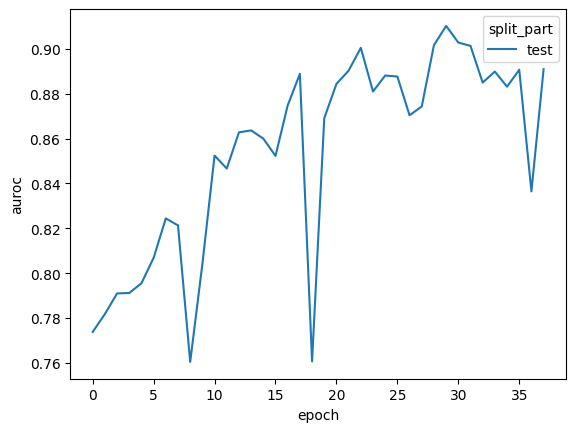

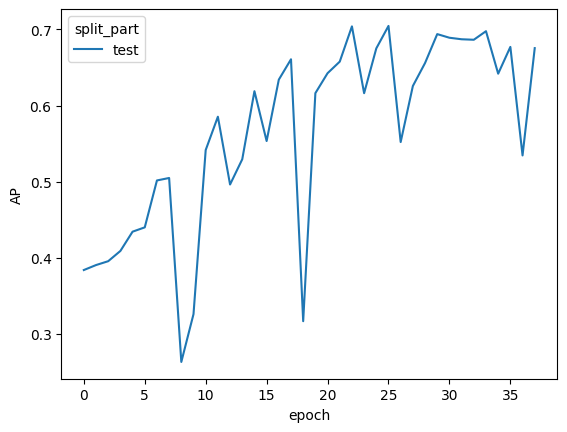

In [25]:
for m in ['auroc', 'AP']:
    sns.lineplot(data=result_df, x='epoch', y=m, hue='split_part')
    plt.show()